In [163]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from decimal import Decimal
from scipy import constants as c

#Graphing variables
page_width = (8.5, 5)

In [237]:
#Calculate accurate floating point uncertainties using the Decimal module

#Uncertainty percentages recorded from 
#ftp://ftp.pasco.com/Support/Documents/english/CI/CI-6630/012-08541b.pdf
a_sensor = 0.001

''' Finds the first significant digit in Decimal object n.
'''
def firstdigit(n):
    abs_n = abs(n)
    place = 0
    if (abs_n >= Decimal('1.0')):
        while (abs_n >= Decimal('10.0')):
            abs_n = Decimal.shift(abs_n, -1)
            place -= 1
    else:
        while (abs_n < Decimal('1.0')):
            abs_n = Decimal.shift(abs_n, 1)
            place += 1
    return round(n, place)

''' Finds the last significant digit in Decimal object n.
'''
def lastdigit(n):
    place = 0
    while (n % Decimal('1.0') == Decimal('0.0')):
        n = Decimal.shift(n, -1)
    while (n % Decimal('1.0') != Decimal('0.0')):
        n = Decimal.shift(n, 1)
        place -= 1
    return place

''' Calculates the maximum uncertainty by taking the larger between the error of
    accuracy and the error of precision.
    Error of accuracy is rounded to one significant digit.
'''
def finderror(x, a):
    dec_x = Decimal(str(np.abs(x)))
    dec_a = Decimal(str(a))
    err_a = firstdigit(dec_x * dec_a)
    err_p = Decimal('1.0') * Decimal(str(10.0**(lastdigit(dec_x))))
    return (float)(max(err_a, err_p))

In [238]:
#Function definitions

''' Plot a function, with optional parameters.
'''
def plot_function(data, weight, filename, title, directory='graphs/', figsize=page_width,
                  plot_error=False, second_data=None, second_label=None):
    plt.figure(figsize=figsize)
    if plot_error:
        plt.errorbar(data[:,0], data[:,1], yerr=weight, elinewidth=0.8, capthick=1.2, capsize=2.0, 
                     fmt='none', label='data')
    else:
        plt.plot(data[:,0], data[:,1], label='data')
    if second_data: 
        plt.plot(second_data[0], second_data[1], label=second_label)
        plt.legend()
    plt.xlabel('Sensor Position (degrees)')
    plt.ylabel('Light Intensity (Volts)')
    plt.title(title)
    plt.savefig(directory+filename+'.png', bbox_inches='tight')

''' Finds the peaks of the data, assuming they are the two greatest values. Returns the angles at which they occur.
'''
def find_peaks(data, u):
    max1, max2 = 0, 0
    for i in range(len(data)):
        if data[i][0] > 10 and data[i][0] < 30 and data[i][1] > max1: 
            max1 = data[i][1]
            angle1 = data[i][0]
            dev = u[i]
    for i in range(len(data)):
        if data[i][0] > 60 and data[i][0] < 75 and data[i][1] > max2: 
            max2 = data[i][1]
            angle2 = data[i][0]
            dev2 = u[i]
    return (angle1, dev, angle2, dev2)

''' Returns the wavelength at this particular angle relative to initial, including uncertainties.
    Converts from parametres in degrees to radians. 
'''
def wavelength(initial, angle, u):
    lambd = np.sqrt(13900/(np.sqrt((2/np.sqrt(3) * np.sin(c.pi/180 * (initial - angle)) + 1/2)**2 + 3/4) - 1.689))
    u *= np.cos(c.pi/180 * (initial - angle))
    u *= 2/np.sqrt(3)
    u *= 2 * (2/np.sqrt(3) * np.sin(c.pi/180 * (initial - angle)) + 1/2)**2 / (2/np.sqrt(3) * np.sin(c.pi/180 * (initial - angle)))
    u *= 13900/(np.sqrt((2/np.sqrt(3) * np.sin(c.pi/180 * (initial - angle)) + 1/2)**2 + 3/4) - 1.689) / ((2/np.sqrt(3) * np.sin(c.pi/180 * (initial - angle)) + 1/2)**2)
    u *= 1/2 * lambd / (13900/(np.sqrt((2/np.sqrt(3) * np.sin(c.pi/180 * (initial - angle)) + 1/2)**2 + 3/4) - 1.689))
    return (lambd, u)

''' Returns the intensity of radiation as defined by Equation (3'). Angles in degrees, temperature in Kelvin. 
'''
def intensity(initial, angle, temperature):
    return 2 * c.pi * c.c**2 * c.h / ((wavelength(initial, angle))**5 * (np.exp(c.h * c.c / (wavelength(initial, angle) * c.k * temperature)) - 1))

''' Returns the power per unit area as defined by Equation (4). Temperature in Kelvin.
'''
def sb_law(temperature):
    return c.sigma * temperature**4

''' Finds the index at which xvalue or yvalue first occurs. Assumes a strictly increasing data set. 
'''
def find_index(data, xvalue, yvalue=None):
    if yvalue: 
        for i in range(len(data)):
            if data[i,1] >= yvalue: return i
    else:
        for i in range(len(data)): 
            if data[i,0] >= xvalue: return i


In [239]:
#Load the data
directory = 'data/'
filenames = ['4.0V0.384A', '4.5V0.412A', '5.0V0.437A(2)', '5.5V0.463A', '6.0V0.481A', '6.5V0.508A', 
             '7.0V0.531A', '7.5V0.549A', '8.0V0.57A', '8.5V0.585A', '9.0V0.606A', '9.5V0.624A', 
             '10.0V0.645A']
vcpairs = np.array([(4.0,0.384), (4.5,0.412), (5.0,0.437), (5.5,0.463), (6.0,0.481), (6.5,0.508), 
                    (7.0,0.531), (7.5,0.549), (8.0,0.57), (8.5,0.585), (9.0,0.606), (9.5,0.624), 
                    (10.0,0.645)])

data, u = [], []
for i in range(len(filenames)):
    data.append(np.loadtxt(directory+filenames[i]+'.txt', skiprows=2))
data = np.array(data)

#Clear zero data at beginning of file
for i in range(len(filenames)):
    while (Decimal((float)(data[i][0][0])) == Decimal('0.0')): data[i] = np.delete(data[i], (0), axis=0)
    u.append([finderror(data[i][j,1], a_sensor) for j in range(len(data[i]))])

data, u = np.array(data), np.array(u)

/Users/hansenHansen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


CPU times: user 7.9 s, sys: 1.49 s, total: 9.39 s
Wall time: 5.44 s


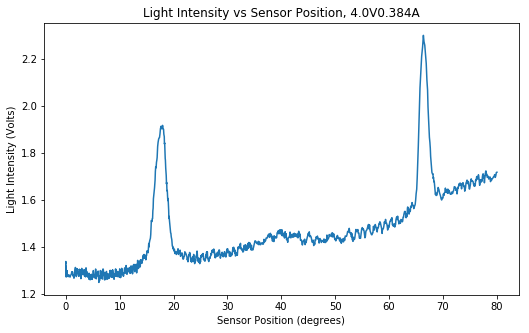

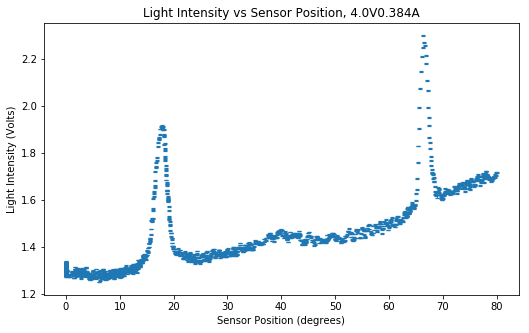

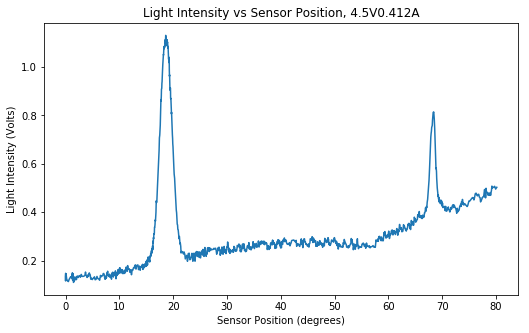

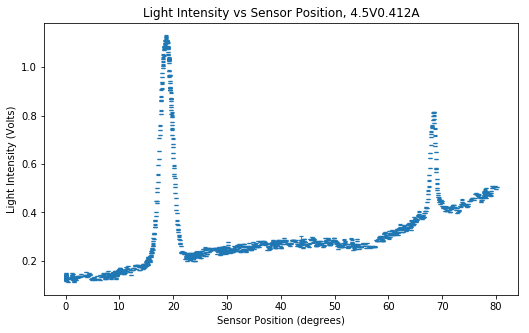

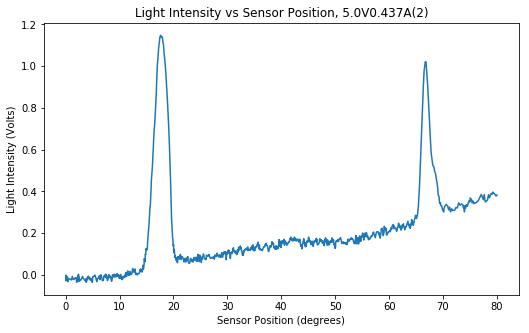

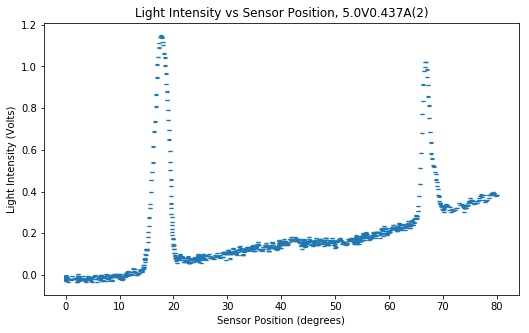

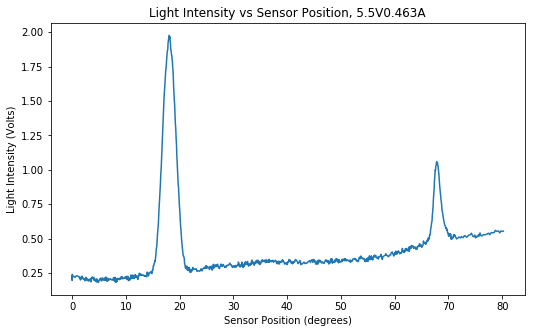

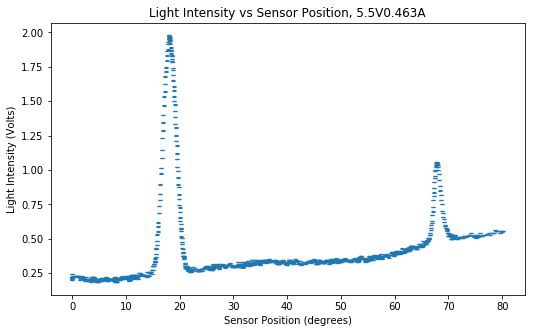

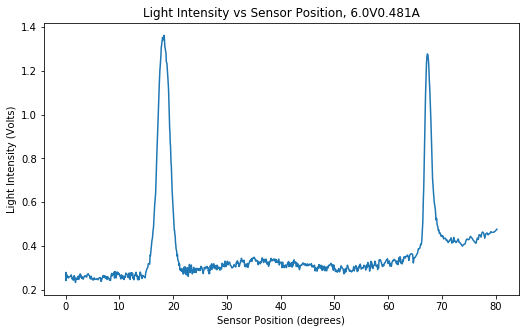

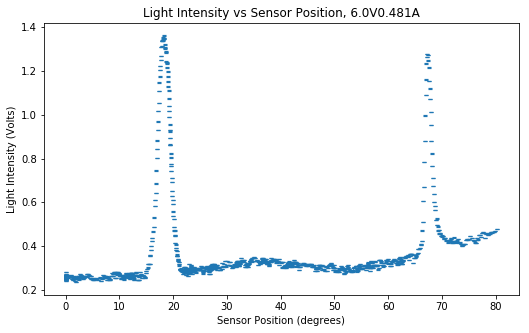

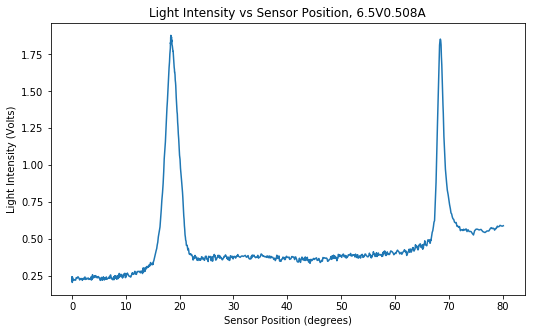

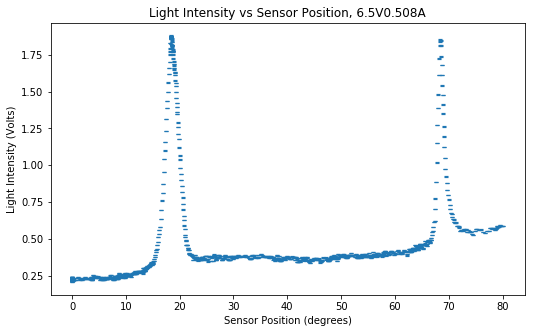

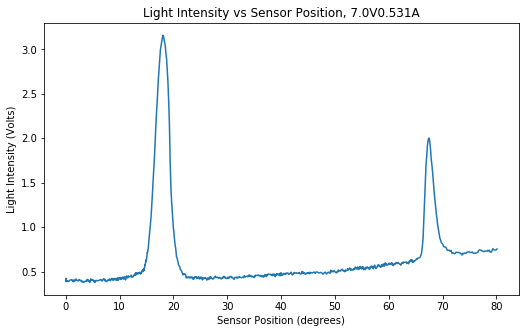

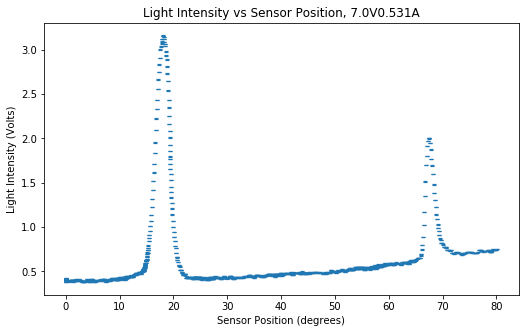

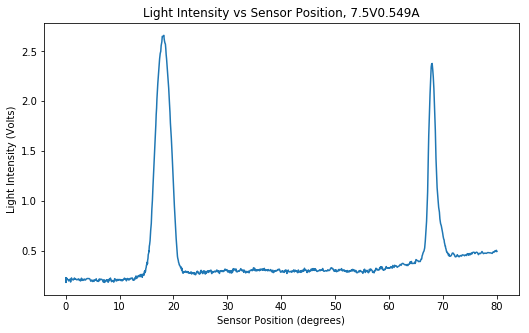

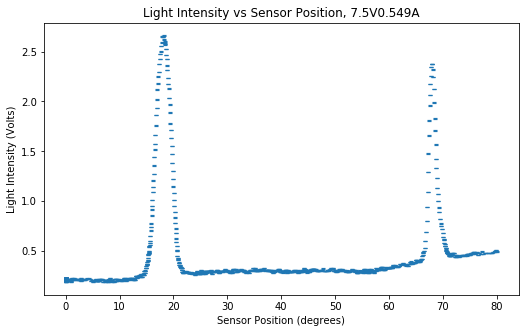

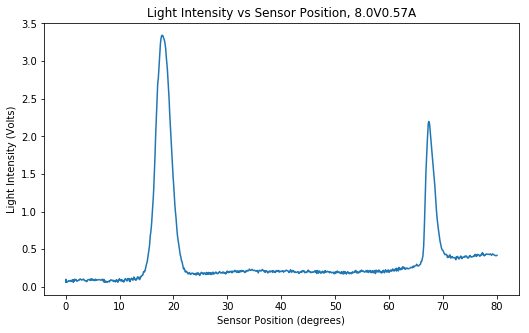

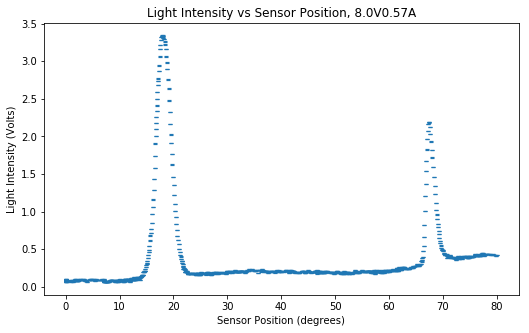

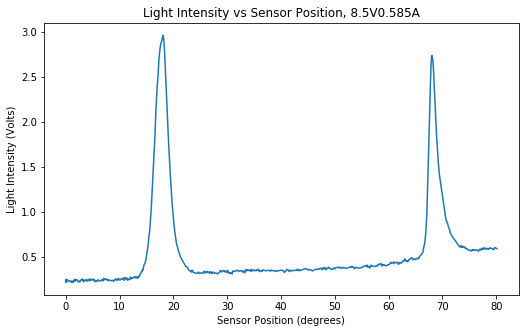

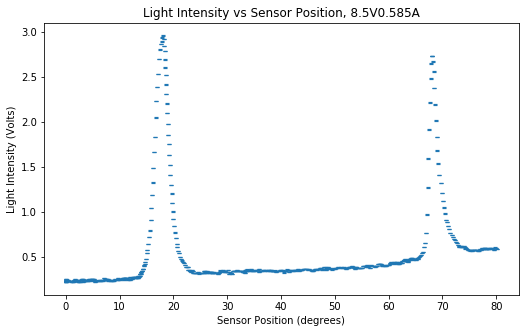

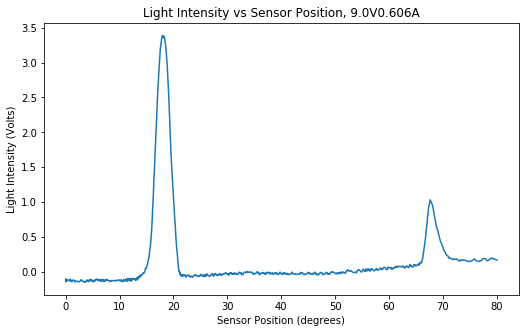

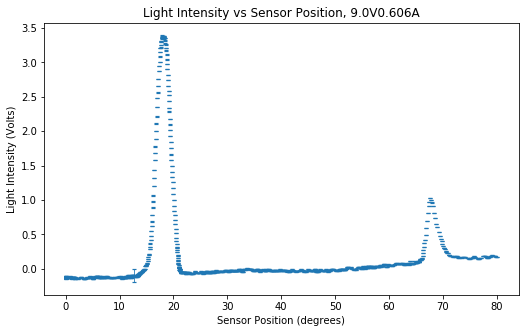

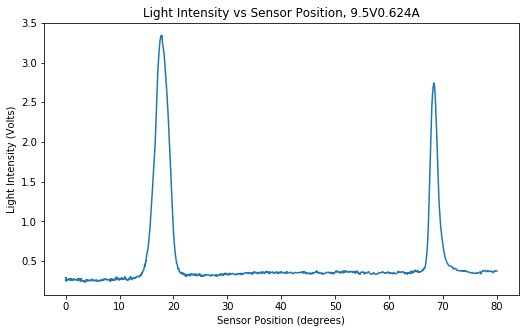

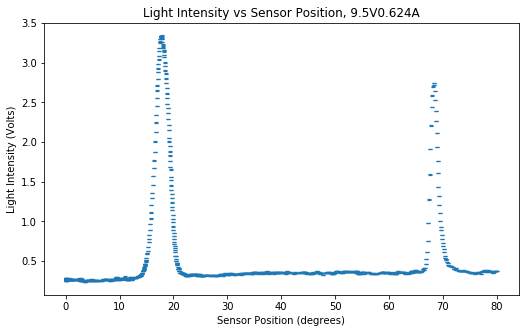

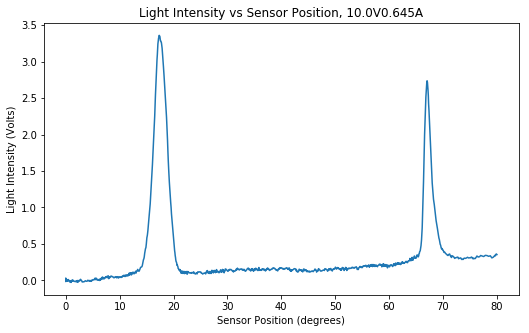

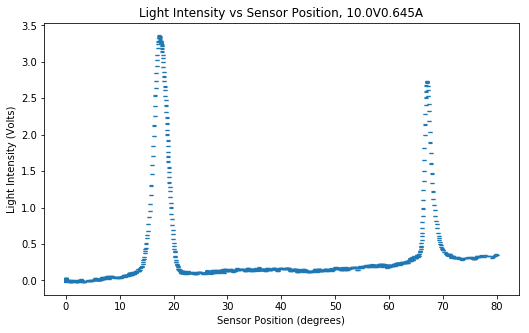

In [240]:
%%time
#CPU times: user 7.61 s, sys: 1.39 s, total: 9 s Wall time: 4.88 s

#Plot data
for i in range(len(data)):
    plot_function(data[i], u[i], filenames[i], 'Light Intensity vs Sensor Position, '+filenames[i],
                  directory='graphs/raw/')
    plot_function(data[i], u[i], filenames[i]+'eb', 'Light Intensity vs Sensor Position, '+filenames[i], 
                  plot_error=True, directory='graphs/rawerror/')

In [241]:
alpha_0 = 4.5 * 10**(-3)  #K^-1
R_0 = 1.1                 #Ohms

angles, temperatures, lambd, wien, u_w = [], [], [], [], []

for i in range(len(data)):
    angles.append(find_peaks(data[i], u[i]))
    temperatures.append((300 + (vcpairs[i,0]/(vcpairs[i,1] * R_0) - 1)/alpha_0, 
                         round((vcpairs[i,0]/vcpairs[i,1] * np.sqrt((0.1/vcpairs[i,0])**2 + (0.001/vcpairs[i,1])**2) * R_0/alpha_0), -1)))
    lambd.append(wavelength(75.7, angles[i][0], angles[i][1]))
    wien.append(lambd[i][0] * 10**(-9) * temperatures[i][0])
    u_w.append(wien[i] * np.sqrt((lambd[i][1]/lambd[i][0])**2 + (temperatures[i][1]/temperatures[i][0])**2))

angles, temperatures, lambd, wien, u_w = np.array(angles), np.array(temperatures), np.array(lambd), np.array(wien), np.array(u_w)

for i in range(len(angles)):
    print('wien=',wien[i],'+-',u_w[i])

wien= 0.0017019201184511592 +- 4.684481511798292e-05
wien= 0.002092903220101344 +- 5.498919691383548e-05
wien= 0.001753217357763997 +- 4.404170827365207e-05
wien= 0.001974296384170827 +- 3.992155161973625e-05
wien= 0.002189172871743624 +- 4.2158695875648024e-05
wien= 0.002277961829026312 +- 4.287525815722664e-05
wien= 0.002213570093635349 +- 4.0599179778000865e-05
wien= 0.002345367788457298 +- 3.336388154055203e-05
wien= 0.0022485697718273236 +- 3.116545307217785e-05
wien= 0.0024278885170340397 +- 3.256069568667684e-05
wien= 0.0024057330894883084 +- 3.1592806649066084e-05
wien= 0.002399785230251843 +- 3.077423734463427e-05
wien= 0.0022391853544278897 +- 2.8208632693987948e-05


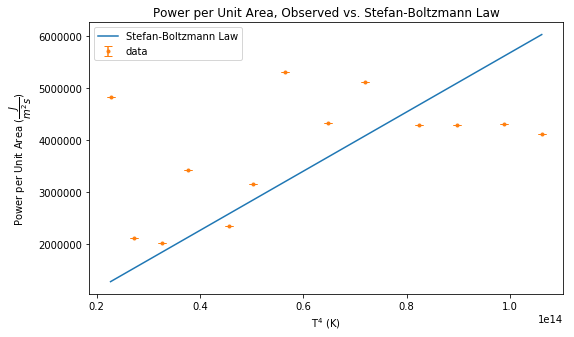

In [261]:
start_angles = np.array([15.3, 16.2, 14.8, 15.3, 15.2, 15.3, 14.6, 14.9, 14.8, 15.0, 14.6, 14.4, 14.0])
finish_angles = np.array([19.8, 21.3, 20.1, 20.9, 21.0, 21.5, 21.1, 21.3, 21.6, 21.3, 20.9, 20.1, 21.0])

areas = [] 

for i in range(len(data)):
    start = find_index(data[i], start_angles[i])
    finish = find_index(data[i], finish_angles[i])
    areas.append(np.trapz(data[i][start:finish,1], x=data[i][start:finish,0]))

areas=np.array(areas)

space = np.linspace(temperatures[0,0],temperatures[-1,0], 1000)
plt.figure(figsize=page_width)
plt.plot(space**4, sb_law(space), label='Stefan-Boltzmann Law')
plt.errorbar(temperatures[:,0]**4, areas*250000/vcpairs[:,1], yerr=0.1, capthick=1.0, capsize=4.0, 
             fmt='.', label='data')
plt.xlabel('T$^4$ (K)')
plt.ylabel('Power per Unit Area ($\dfrac{J}{m^2s}$)')
plt.title('Power per Unit Area, Observed vs. Stefan-Boltzmann Law')
plt.legend()
plt.savefig('graphs/sbcomparison3.png', bbox_inches='tight')